In [1]:
# import the packages
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score

<p>We are using F1 Score as model performance metric because its more appropriate in an imbalanced class problem</p>

<h3>Get the data</h3>

In [2]:
train = pd.read_csv('dataset/train.csv')
train.head()

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,area_code_area_code_415,area_code_area_code_510
0,97,1,0,0,236.9,107,105,13.40,241.0,120,2,1.97,0,1,0,1
1,28,0,0,0,168.2,87,92,13.74,192.4,112,3,2.73,3,0,1,0
2,120,0,0,0,180.0,80,82,19.06,265.4,91,7,1.27,3,0,1,0
3,80,0,1,33,189.4,109,68,12.64,208.9,119,4,3.02,1,1,1,0
4,100,0,0,0,239.1,96,110,15.31,259.2,112,2,3.78,0,0,0,0


In [3]:
test = pd.read_csv('dataset/test.csv')
test.head()

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,area_code_area_code_415,area_code_area_code_510
0,65,0,0,0,111.0,51,84,18.68,202.0,89,14,1.19,1,0,1,0
1,64,0,0,0,206.2,76,76,19.75,251.6,96,2,3.67,1,0,1,0
2,125,0,0,0,126.7,108,90,17.51,247.8,114,7,3.59,1,0,0,0
3,117,0,1,13,207.6,65,77,12.98,232.8,95,3,2.62,1,0,0,0
4,149,0,0,0,175.4,80,127,16.78,188.2,102,2,2.62,2,0,0,0


<p>We will use the test set only for final report on model performance</p>

In [4]:
# split the train data into train-dev set
from sklearn.model_selection import train_test_split

X = train.drop(['churn'], axis=1)
y = train['churn']

X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.2, random_state=42)

<h3>LightGBM Classifier (vanilla)</h3>

In [5]:
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

lgb_basic = lgb.LGBMClassifier()
lgb_basic.fit(X_train, y_train)

y_pred = np.array(lgb_basic.predict(X_dev))

print('F1 score: {:.3f}'.format(f1_score(y_dev, y_pred)))

F1 score: 0.835


In [6]:
# hyperparameters tuning
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV

clf = lgb.LGBMClassifier()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

space = dict()
space['n_estimators'] = [100, 150, 200, 250]
space['learning_rate'] = [0.01, 0.05, 0.1, 0.5]
space['min_child_samples'] = [20, 30, 40]
space['num_leaves'] = [50, 60, 70]
space['is_unbalance'] = [True]

clf_random = RandomizedSearchCV(clf, space, scoring='f1', n_iter=100, cv=cv, verbose=2, n_jobs=-1)
clf_random.fit(X_train, y_train)

Fitting 15 folds for each of 100 candidates, totalling 1500 fits


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=42),
                   estimator=LGBMClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'is_unbalance': [True],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.5],
                                        'min_child_samples': [20, 30, 40],
                                        'n_estimators': [100, 150, 200, 250],
                                        'num_leaves': [50, 60, 70]},
                   scoring='f1', verbose=2)

In [7]:
print('Best hyperparameters: {}'.format(clf_random.best_params_))

Best hyperparameters: {'num_leaves': 50, 'n_estimators': 100, 'min_child_samples': 20, 'learning_rate': 0.1, 'is_unbalance': True}


In [8]:
from sklearn.model_selection import GridSearchCV

clf = lgb.LGBMClassifier()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

space = dict()
space['n_estimators'] = [20, 60, 80, 100]
space['learning_rate'] = [0.1]
space['min_child_samples'] = [10, 15, 20]
space['num_leaves'] = [30, 40, 50]
space['is_unbalance'] = [True]

clf_grid = GridSearchCV(clf, space, scoring='f1', cv=cv, n_jobs=-1)
clf_grid.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=42),
             estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'is_unbalance': [True], 'learning_rate': [0.1],
                         'min_child_samples': [10, 15, 20],
                         'n_estimators': [20, 60, 80, 100],
                         'num_leaves': [30, 40, 50]},
             scoring='f1')

In [9]:
y_pred = np.array(clf_grid.predict(X_dev))

print('F1 score: {:.3f}'.format(f1_score(y_dev, y_pred)))
print('Best hyperparameters: {}'.format(clf_grid.best_params_))

F1 score: 0.838
Best hyperparameters: {'is_unbalance': True, 'learning_rate': 0.1, 'min_child_samples': 20, 'n_estimators': 100, 'num_leaves': 30}


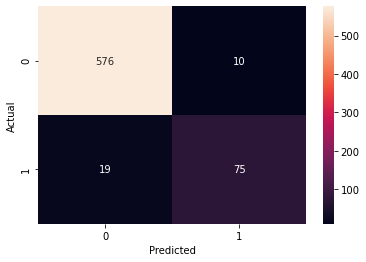

In [10]:
import seaborn as sns

conf_matrix = pd.crosstab(y_dev, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(conf_matrix, annot=True, fmt='g');

<h3>LGBMClassifier with SMOTE over-sampling</h3>

In [11]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

clf = lgb.LGBMClassifier()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

space = dict()
space['n_estimators'] = [20, 60, 80, 100]
space['learning_rate'] = [0.1]
space['min_child_samples'] = [10, 15, 20]
space['num_leaves'] = [30, 40, 50]
# space['is_unbalance'] = [True]

clf_smote = GridSearchCV(clf, space, scoring='f1', cv=cv, n_jobs=-1)
clf_smote.fit(X_train_res, y_train_res)

y_pred = np.array(clf_smote.predict(X_dev))

print('F1 score: {:.3f}'.format(f1_score(y_dev, y_pred)))
print('Best hyperparameters: {}'.format(clf_smote.best_params_))

F1 score: 0.772
Best hyperparameters: {'learning_rate': 0.1, 'min_child_samples': 10, 'n_estimators': 100, 'num_leaves': 50}


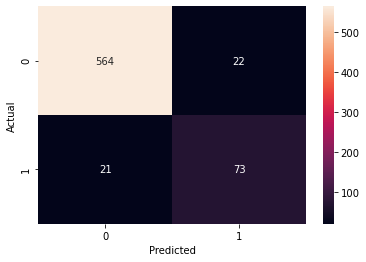

In [12]:
conf_matrix = pd.crosstab(y_dev, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(conf_matrix, annot=True, fmt='g');

<h3>LGBMClassifier: combination of SMOTE over-sampling with random undersampling</h3>

In [13]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.6)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_train_res, y_train_res = pipeline.fit_resample(X_train, y_train)

clf = lgb.LGBMClassifier()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

space = dict()
space['n_estimators'] = [20, 60, 80, 100]
space['learning_rate'] = [0.1]
space['min_child_samples'] = [10, 15, 20]
space['num_leaves'] = [30, 40, 50]
# space['is_unbalance'] = [True]

clf_comb = GridSearchCV(clf, space, scoring='f1', cv=cv, n_jobs=-1)
clf_comb.fit(X_train_res, y_train_res)

y_pred = np.array(clf_comb.predict(X_dev))

print('F1 score: {:.3f}'.format(f1_score(y_dev, y_pred)))
print('Best hyperparameters: {}'.format(clf_comb.best_params_))

F1 score: 0.798
Best hyperparameters: {'learning_rate': 0.1, 'min_child_samples': 15, 'n_estimators': 100, 'num_leaves': 40}


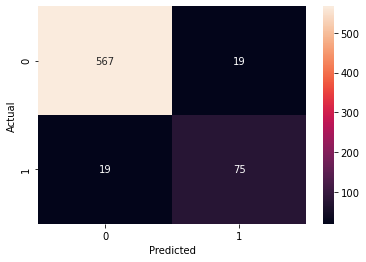

In [14]:
conf_matrix = pd.crosstab(y_dev, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(conf_matrix, annot=True, fmt='g');

<p>It seems like tuned LGBMClassifier method generates a higher F1 Score than any other methods</p>

<h3>Put all the pieces together</h3>

In [15]:
X_test = test.drop(['churn'], axis=1)
y_test = test['churn']

clf_grid.fit(X, y)

y_pred = np.array(clf_grid.predict(X_test))

print('F1 score: {:.3f}'.format(f1_score(y_test, y_pred)))
print('Best hyperparameters: {}'.format(clf_grid.best_params_))

F1 score: 0.867
Best hyperparameters: {'is_unbalance': True, 'learning_rate': 0.1, 'min_child_samples': 15, 'n_estimators': 100, 'num_leaves': 40}


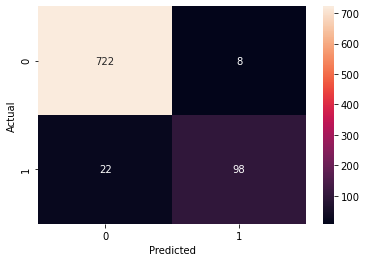

In [16]:
conf_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(conf_matrix, annot=True, fmt='g');

In [17]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_pred))

0.9647058823529412
